In [44]:
%load_ext autoreload
%autoreload 2
%aimport -numpy, -matplotlib, -IPython
from IPython.display import display
import l2a_analysis as l2aa
from helpers import get_stats_average, plot_true_color_image, plot_difference_histogram, multiplot_difference_histogram



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
locs = {
    "CH": "S2A_MSIL1C_20230903T101601_N0509_R065_T32TMS_20230903T140124.SAFE",
    "BRA": "S2A_MSIL1C_20230909T141721_N0509_R010_T21MTS_20230909T192148.SAFE",
    'ALG' : 'S2B_MSIL1C_20230904T103629_N0509_R008_T30RXT_20230904T125735.SAFE'
}

# NO_DATA, SATURATED_OR_DEFECTIVE, CASTED_SHADOWS, CLOUD_SHADOWS, VEGETATION, NOT_VEGETATED, WATER, UNCLASSIFIED, CLOUD_MEDIUM_PROBABILITY, CLOUD_HIGH_PROBABILITY, THIN_CIRRUS, SNOW
modifications = [
    {
        'flag' : 'SEN2COR_MOD_SC_ONLY',
        'value' : '1',
        'info' : 'Run sen2cor with only the scence classification (no atmospheric correction)',
        'name' : 'SC_ONLY'
    },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "4",
        "info": "Set whole SCL layer to VEGETATION",
        "name": "class_VEGETATION",
    },
]

SC_const_labels = [
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '0',
        'info' : 'Set whole SCL layer to NO_DATA',
        'name' : 'class_NO_DATA'
    },
    # {
    #     'flag' : 'SEN2COR_MOD_const_class',
    #     'value' : '1',
    #     'info' : 'Set whole SCL layer to SATURATED_OR_DEFECTIVE',
    #     'name' : 'class_SATURATED_OR_DEFECTIVE'
    # },
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '2',
        'info' : 'Set whole SCL layer to CASTED_SHADOWS',
        'name' : 'class_CASTED_SHADOWS'
    },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "3",
        "info": "Set whole SCL layer to CLOUD_SHADOWS",
        "name": "class_CLOUD_SHADOWS",
    },
    {
        "flag": "SEN2COR_MOD_const_class",
        "value": "4",
        "info": "Set whole SCL layer to VEGETATION",
        "name": "class_VEGETATION",
    },
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '5',
        'info' : 'Set whole SCL layer to NOT_VEGETATED',
        'name' : 'class_NOT_VEGETATED'
    },
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '6',
        'info' : 'Set whole SCL layer to WATER',
        'name' : 'class_WATER'
    },
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '7',
        'info' : 'Set whole SCL layer to UNCLASSIFIED',
        'name' : 'class_UNCLASSIFIED'
    },
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '8',
        'info' : 'Set whole SCL layer to CLOUD_MEDIUM_PROBABILITY',
        'name' : 'class_CLOUD_MEDIUM_PROBABILITY'
    },
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '9',
        'info' : 'Set whole SCL layer to CLOUD_HIGH_PROBABILITY',
        'name' : 'class_CLOUD_HIGH_PROBABILITY'
    },
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '10',
        'info' : 'Set whole SCL layer to THIN_CIRRUS',
        'name' : 'class_THIN_CIRRUS'
    },
    {
        'flag' : 'SEN2COR_MOD_const_class',
        'value' : '11',
        'info' : 'Set whole SCL layer to SNOW',
        'name' : 'class_SNOW'
    },
]

In [24]:
l2a_analysis = l2aa.L2A_Analysis(report_name="TEST5")
l2a_analysis.set_locations(locs)
l2a_analysis.set_modifications(SC_const_labels)

In [25]:

l2a_analysis.run_sen2cor()
l2a_analysis.read_l2a_data()

CH:	reference already exists. Skipping...
BRA:	reference already exists. Skipping...
ALG:	reference already exists. Skipping...
CH:	class_NO_DATA already exists. Skipping...
BRA:	class_NO_DATA already exists. Skipping...
ALG:	class_NO_DATA already exists. Skipping...
CH:	class_CASTED_SHADOWS already exists. Skipping...
BRA:	class_CASTED_SHADOWS already exists. Skipping...
ALG:	class_CASTED_SHADOWS already exists. Skipping...
CH:	class_CLOUD_SHADOWS already exists. Skipping...
BRA:	class_CLOUD_SHADOWS already exists. Skipping...
ALG:	class_CLOUD_SHADOWS already exists. Skipping...
CH:	class_VEGETATION already exists. Skipping...
BRA:	class_VEGETATION already exists. Skipping...
ALG:	class_VEGETATION already exists. Skipping...
CH:	class_NOT_VEGETATED already exists. Skipping...
BRA:	class_NOT_VEGETATED already exists. Skipping...
ALG:	class_NOT_VEGETATED already exists. Skipping...
CH:	class_WATER already exists. Skipping...
BRA:	class_WATER already exists. Skipping...
ALG:	class_WATER 

In [26]:
# loc = 'CH'
# mod = 'class_NO_DATA'

# plot_true_color_image(l2a_analysis.reference_bands[loc])
# plot_true_color_image(l2a_analysis.modified_bands[loc][mod])

In [27]:
loc = 'CH'
mod = 'class_NO_DATA'
stat_bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B8A", "B11", "B12"]
stats = get_stats_average(l2a_analysis.reference_bands[loc], l2a_analysis.modified_bands[loc][mod], stat_bands)
display(stats)



mean       9.621222
std      161.361465
max     2031.222168
min    -4684.888672
dtype: float32

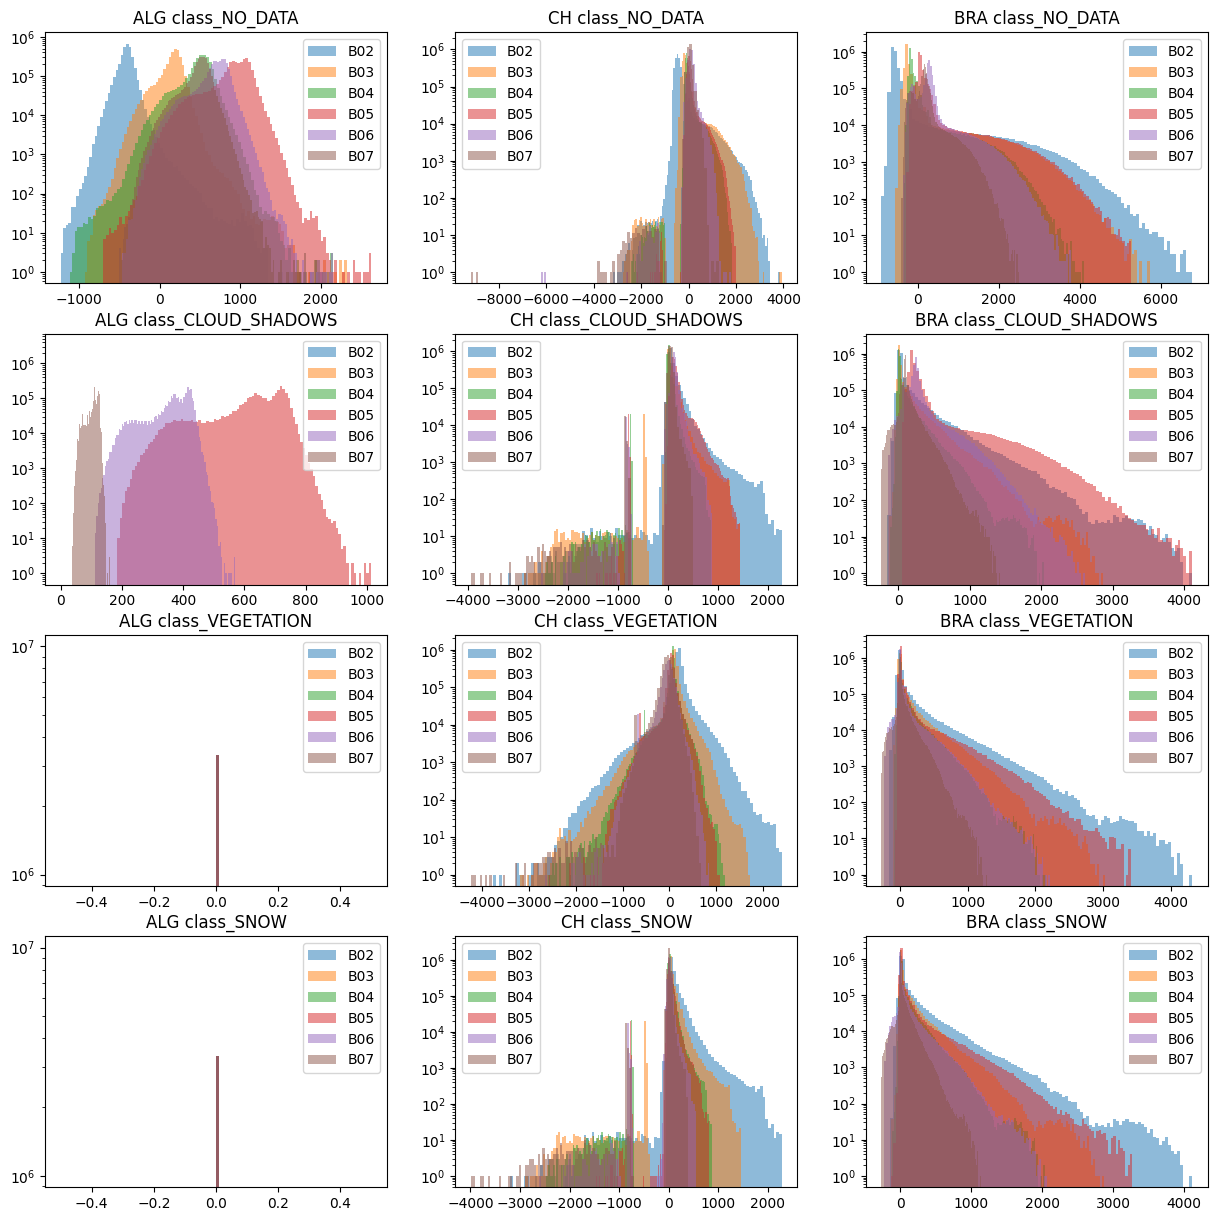

In [28]:

locs = ['ALG', 'CH', 'BRA']
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07']
mods = ['class_NO_DATA',  'class_CLOUD_SHADOWS', 'class_VEGETATION', 'class_SNOW']
# mods = ['SC_ONLY', 'class_NO_DATA']
multiplot_difference_histogram(l2a_analysis, locs, mods, bands)

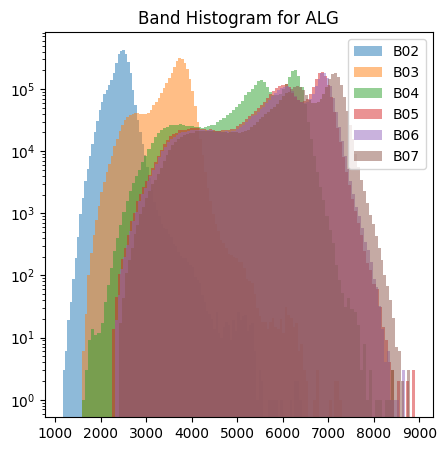

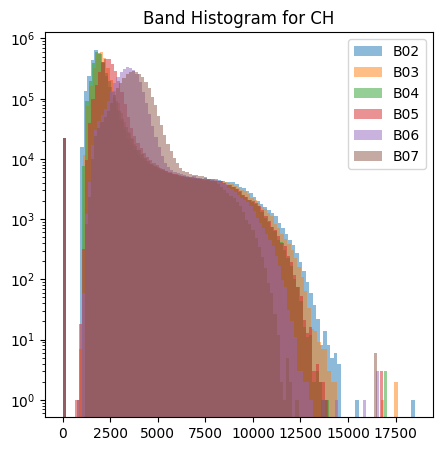

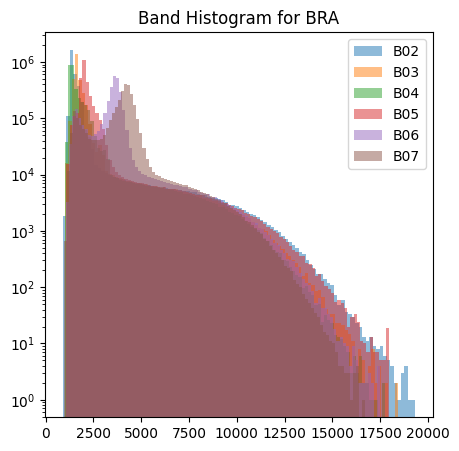

In [29]:
from helpers import plot_difference_histogram, plot_band_histogram
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07']
locs = ['ALG', 'CH', 'BRA']
# for loc in locs:
#     for mod in mods:
#         plot_title = f"Difference Histogram for {loc} with {mod}"
#         plot_difference_histogram(l2a_analysis.reference_bands[loc],l2a_analysis.modified_bands[loc][mod],bands,plot_title=plot_title)

for loc in locs:
    plot_title = f"Band Histogram for {loc}"
    plot_band_histogram(l2a_analysis.reference_bands[loc],bands,plot_title=plot_title)

In [30]:
from helpers import get_stats_average_multi
locs = ['ALG', 'CH', 'BRA']
mods = ['class_NO_DATA',  'class_CLOUD_SHADOWS', 'class_VEGETATION', 'class_SNOW']
bands = ['B02', 'B03', 'B04']
stats = get_stats_average_multi(l2a_analysis, locs, mods, bands)
print("Standard Deviation")
display(stats['std'])
print("Mean")
display(stats['mean'])
print("Max")
display(stats['max'])
print("Min")
display(stats['min'])


Standard Deviation


,class_NO_DATA,class_CLOUD_SHADOWS,class_VEGETATION,class_SNOW
ALG,141.871170,0.000000,0.000000,0.000000
CH,275.587952,104.527443,155.910965,104.527443
BRA,488.072540,170.107346,185.812073,170.107346


Mean


,class_NO_DATA,class_CLOUD_SHADOWS,class_VEGETATION,class_SNOW
ALG,68.252892,0.000000,0.000000,0.000000
CH,-150.120392,59.230854,118.565407,59.230854
BRA,-196.312317,81.316231,70.239510,81.316231


Max


,class_NO_DATA,class_CLOUD_SHADOWS,class_VEGETATION,class_SNOW
ALG,2167.000000,0.000000,0.000000,0.000000
CH,3214.333252,1535.666626,1771.333374,1535.666626
BRA,5532.333496,3001.666748,3165.666748,3001.666748


Min


,class_NO_DATA,class_CLOUD_SHADOWS,class_VEGETATION,class_SNOW
ALG,-1095.666626,0.000000,0.0,0.000000
CH,-2792.666748,-2851.666748,-3180.0,-2851.666748
BRA,-606.000000,-132.333328,-115.0,-132.333328


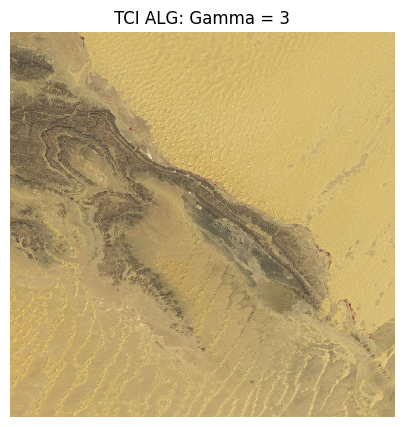

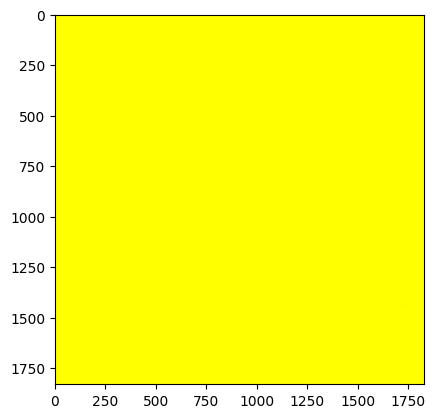

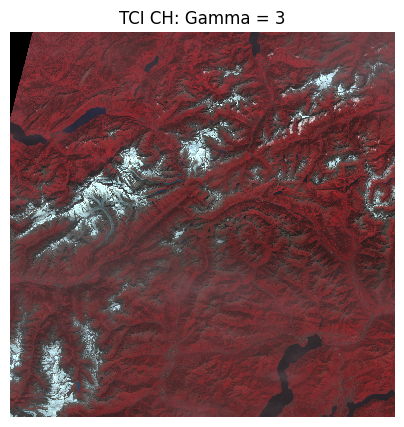

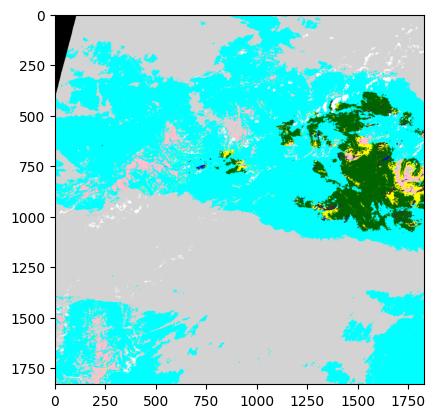

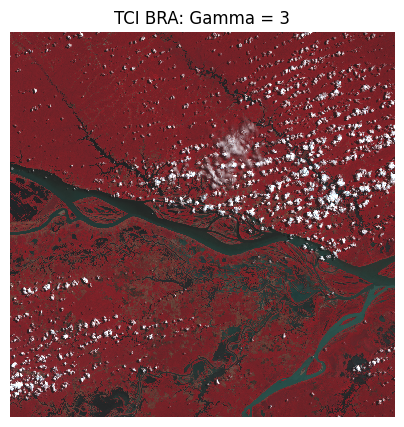

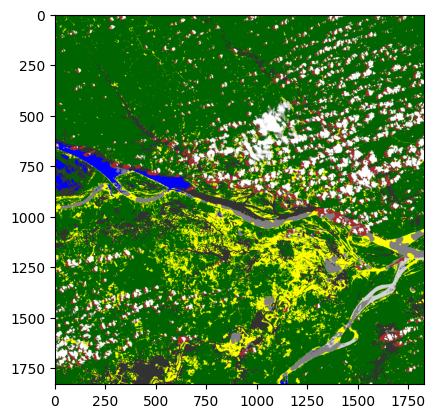

In [46]:
from helpers import plot_scl_in_rgb
loc = 'BRA'
for loc in locs:
    SCL = l2a_analysis.reference_bands[loc]['SCL']
    plot_true_color_image(l2a_analysis.reference_bands[loc], gamma=3, title=f"TCI {loc}: Gamma = 3", clip_value=10000)
    plot_scl_in_rgb(SCL)


In [32]:
import numpy as np
clip_value = 10000

product = l2a_analysis.reference_bands[loc]

blue = product["B02"].read() 
green = product["B03"].read() 
red = product["B04"].read() 
green[0,2] = 20000
rgb = np.dstack((red, green, blue))
rgb = rgb[0:10, 0:10, :]
rgb[0,0,0] = 20000
# clip values
mask = [rgb > clip_value]

In [33]:
product = l2a_analysis.reference_bands[loc]
#pretty print
from pprint import pprint
pprint(product["B02"].meta)



{'count': 1,
 'crs': CRS.from_epsg(32721),
 'driver': 'JP2OpenJPEG',
 'dtype': 'uint16',
 'height': 1830,
 'nodata': None,
 'transform': Affine(60.0, 0.0, 199980.0,
       0.0, -60.0, 9700000.0),
 'width': 1830}


In [47]:
from helpers import get_max_difference_to_l2a

max_diff, max_id = get_max_difference_to_l2a(l2a_analysis, loc, mods, bands)




'<l2a_analysis.L2A_Band object at 0x7f911a1a63b0> jp2_path: /scratch/toml/sentinel_2_data/reports/TEST5/BRA/reference/S2A_MSIL2A_20230909T141721_N9999_R010_T21MTS_20230920T134300.SAFE/GRANULE/L2A_T21MTS_A042907_20230909T141842/IMG_DATA/R60m//T21MTS_20230909T141721_B05_60m.jp2'